In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization,
                                     Activation, Dropout, Flatten, Dense)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# ----------------------------
# 1. Model Architecture: ScriptNet
# ----------------------------
def build_scriptnet(input_shape=(32, 32, 1), num_classes=83):
    inputs = Input(shape=input_shape, name='input_layer')

    x = Conv2D(64, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    x = Flatten()(x)
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation='softmax', name='output_layer')(x)

    model = Model(inputs=inputs, outputs=outputs, name='ScriptNet')
    return model

2025-06-01 02:28:25.707958: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748744905.938754      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748744906.005397      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import pandas as pd
import cv2
from tqdm import tqdm

# ---------------------------------------------
# Step 2: Convert EMNIST CSV to Image Folders (32x32)
# ---------------------------------------------
def save_emnist_images(csv_path, output_dir, img_size=(32, 32)):
    os.makedirs(output_dir, exist_ok=True)

    df = pd.read_csv(csv_path, header=None)
    labels = df.iloc[:, 0].values.astype(int)
    images = df.iloc[:, 1:].values.reshape(-1, 28, 28).astype('uint8')

    for idx, (label, image) in enumerate(tqdm(zip(labels, images), total=len(labels))):
        label_dir = os.path.join(output_dir, str(label))
        os.makedirs(label_dir, exist_ok=True)

        # Rotate + flip to fix EMNIST orientation
        image = np.transpose(image, (1, 0))
        image = cv2.flip(image, 0)

        # Resize to 32x32
        image = cv2.resize(image, img_size, interpolation=cv2.INTER_AREA)

        img_path = os.path.join(label_dir, f"{idx}.png")
        cv2.imwrite(img_path, image)

# Convert train and test CSVs to image folders
save_emnist_images('/kaggle/input/emnist/emnist-balanced-train.csv', 'emnist_balanced_images/train')
save_emnist_images('/kaggle/input/emnist/emnist-balanced-test.csv', 'emnist_balanced_images/test')

# ---------------------------------------------
# Step 2.2: Load Data with ImageDataGenerator
# ---------------------------------------------
image_size = (32, 32)
input_shape = (32, 32, 1)
batch_size = 64
epochs = 30
num_classes = 47  # Update if using fewer classes

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    'emnist_balanced_images/train',
    target_size=image_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='sparse',
    subset='training',
    seed=42,
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    'emnist_balanced_images/train',
    target_size=image_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation',
    seed=42,
    shuffle=False
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'emnist_balanced_images/test',
    target_size=image_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)


100%|██████████| 18800/18800 [00:03<00:00, 5666.81it/s]


Found 90240 images belonging to 47 classes.
Found 22560 images belonging to 47 classes.
Found 18800 images belonging to 47 classes.


In [5]:
from tensorflow.keras.layers import SeparableConv2D

# ----------------------------
# 3. Compile Model
# ----------------------------
model = build_scriptnet(input_shape=input_shape, num_classes=num_classes)
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

I0000 00:00:1748745566.338418      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748745566.339068      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "ScriptNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,495,279 (9.52 MB)

 Trainable params: 2,493,359 (9.51 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [6]:
# ----------------------------
# 4. Callbacks
# ----------------------------
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=7, min_delta=0.001, restore_best_weights=True),
    ModelCheckpoint("scriptnet_banglalekha_best.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
]

epochs=60

# ----------------------------
# 5. Train Model
# ----------------------------
steps_per_epoch = np.ceil(train_generator.samples / batch_size).astype(int)
validation_steps = np.ceil(val_generator.samples / batch_size).astype(int)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1748745613.859292     145 service.cc:148] XLA service 0x7a65a40086d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748745613.860375     145 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748745613.860401     145 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748745614.404841     145 cuda_dnn.cc:529] Loaded cuDNN version 90300


  13/1410 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.0592 - loss: 4.3836

I0000 00:00:1748745620.376426     145 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1407/1410 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6596 - loss: 1.1829
Epoch 1: val_accuracy improved from -inf to 0.85855, saving model to scriptnet_banglalekha_best.h5
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 38s 19ms/step - accuracy: 0.6599 - loss: 1.1816 - val_accuracy: 0.8586 - val_loss: 0.4137 - learning_rate: 0.0010
Epoch 2/60
1409/1410 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8366 - loss: 0.4776
Epoch 2: val_accuracy improved from 0.85855 to 0.86596, saving model to scriptnet_banglalekha_best.h5
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 25s 18ms/step - accuracy: 0.8366 - loss: 0.4776 - val_accuracy: 0.8660 - val_loss: 0.3751 - learning_rate: 0.0010
Epoch 3/60
1408/1410 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8537 - loss: 0.4178
Epoch 3: val_accuracy improved from 0.86596 to 0.87624, saving model to scriptnet_banglalekha_best.h5
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step - accuracy: 0.8537 - loss: 0.4178 - val_accuracy: 0.8762 - val_loss: 0.3442 - learning_rate: 0.0010
Epoch 

In [7]:
# ---------------------------------------------
# Step 5: Evaluate and Save Model
# ---------------------------------------------
score = model.evaluate(test_generator, verbose=0)
print(f"Test Loss: {score[0]:.4f}")
print(f"Test Accuracy: {score[1]:.4f}")

model.save('emnist_balanced_model_32x32.h5')


Test Loss: 0.3109
Test Accuracy: 0.8991


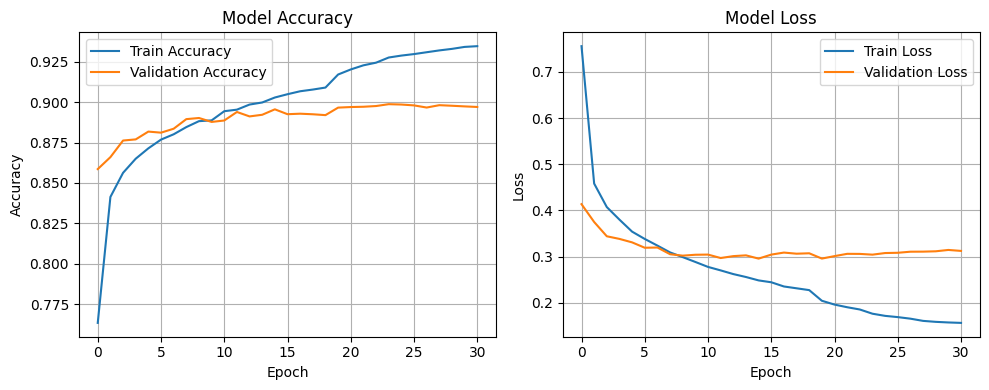

In [8]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

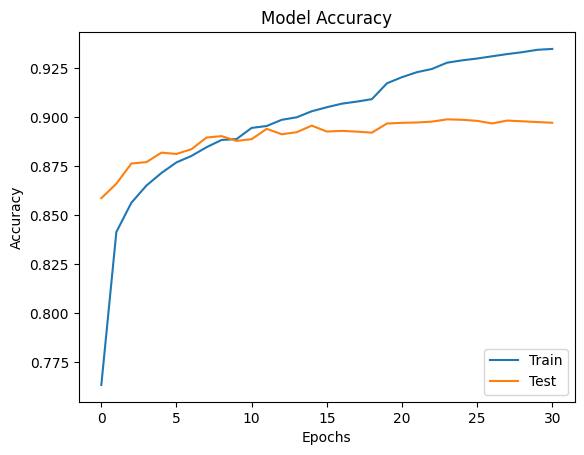

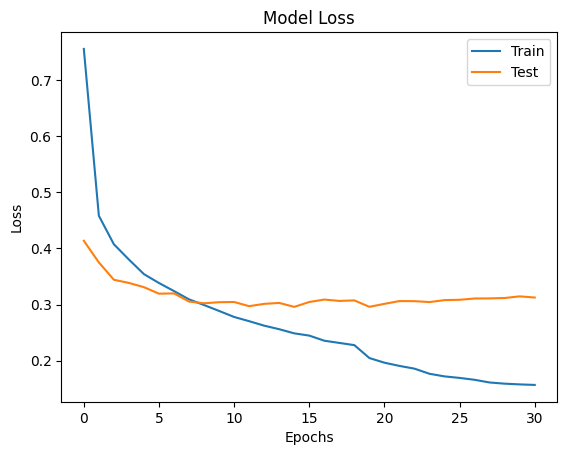

In [9]:
# plot the convergence, in terms of accuracy and loss, of ScriptNet
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

353/353 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step


<Figure size 1200x1200 with 0 Axes>

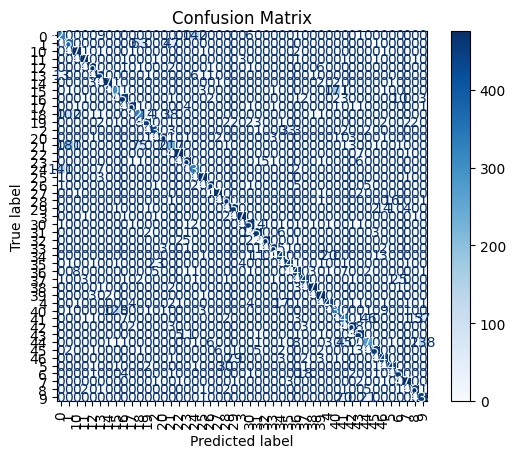

In [10]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = val_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices.keys())
plt.figure(figsize=(12, 12))
disp.plot(cmap='Blues', xticks_rotation=90)
plt.title("Confusion Matrix")
plt.show()

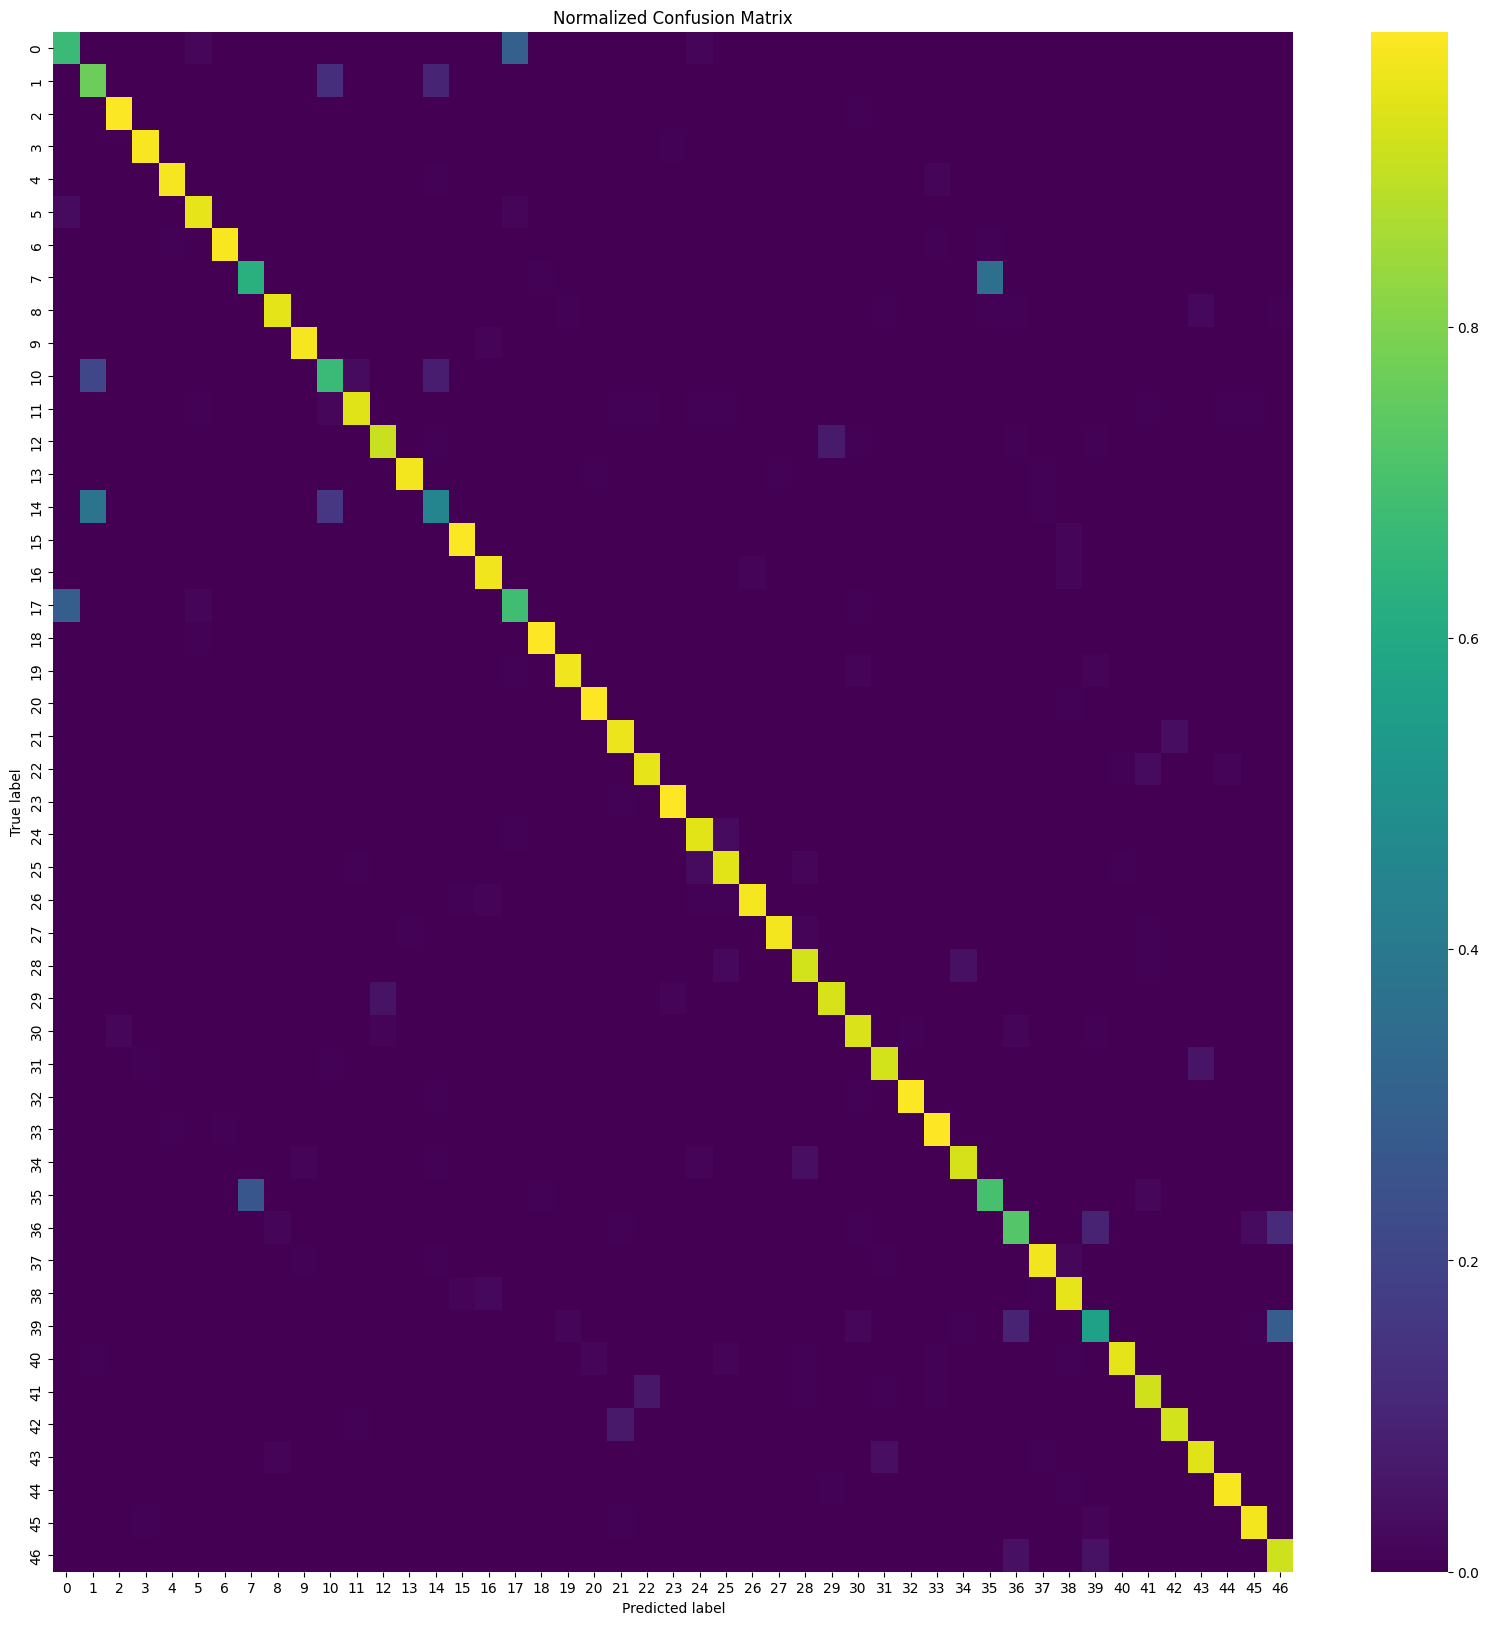

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# true and predicted labels
cm = confusion_matrix(y_true, y_pred, labels=range(47))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(20, 20))
sns.heatmap(cm_normalized, annot=False, cmap='viridis')
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


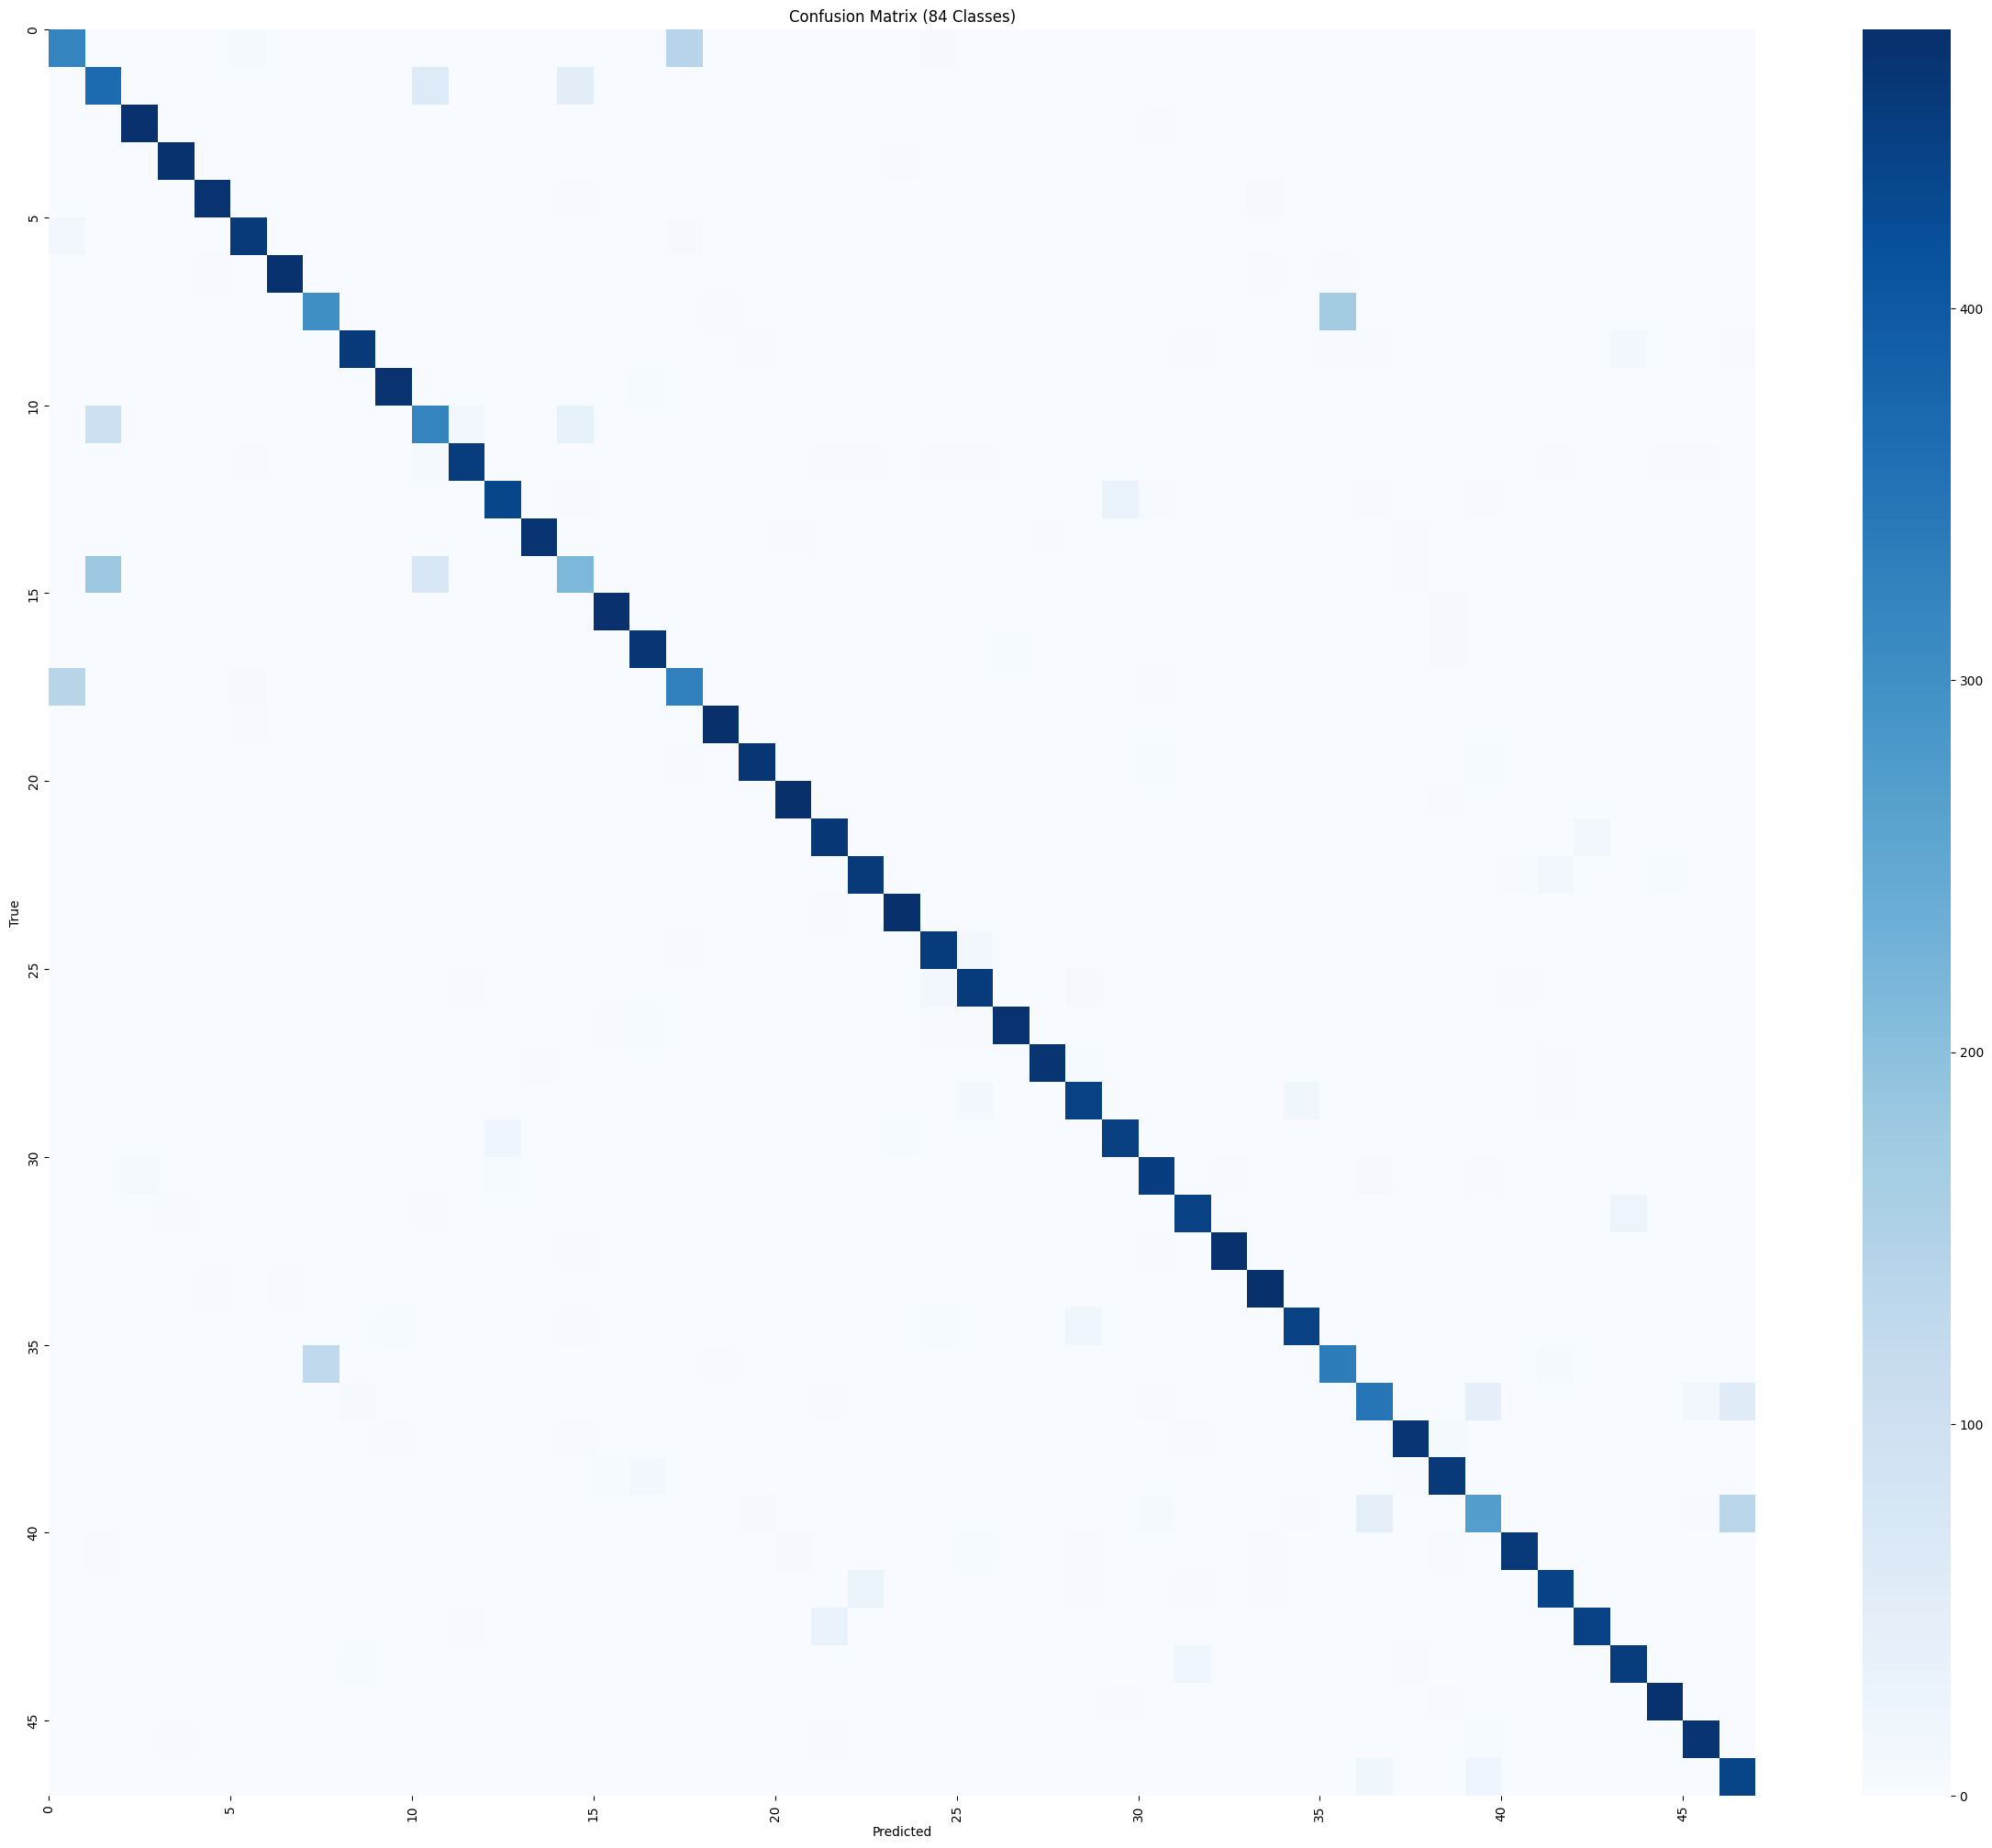

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(30, 25))  # Bigger figure
sns.heatmap(cm, annot=False, cmap='Blues', cbar=True)
plt.title('Confusion Matrix (84 Classes)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=range(0, 47, 5), labels=range(0, 47, 5), rotation=90)  # Sparse ticks
plt.yticks(ticks=range(0, 47, 5), labels=range(0, 47, 5))
plt.show()


In [14]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Predict and true labels (already obtained previously)
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes
class_names = list(val_generator.class_indices.keys())

# Print classification report
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print("📋 Classification Report:\n")
print(report)

# Extract and print macro, weighted scores
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

precision_weighted = precision_score(y_true, y_pred, average='weighted')
recall_weighted = recall_score(y_true, y_pred, average='weighted')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print("🔢 Macro Scores")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro):    {recall_macro:.4f}")
print(f"F1-score (Macro):  {f1_macro:.4f}")

print("\n🔢 Weighted Scores")
print(f"Precision (Weighted): {precision_weighted:.4f}")
print(f"Recall (Weighted):    {recall_weighted:.4f}")
print(f"F1-score (Weighted):  {f1_weighted:.4f}")


353/353 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
📋 Classification Report:

              precision    recall  f1-score   support

           0     0.6701    0.6687    0.6694       480
           1     0.5616    0.7688    0.6491       480
          10     0.9773    0.9854    0.9813       480
          11     0.9812    0.9812    0.9812       480
          12     0.9730    0.9750    0.9740       480
          13     0.9481    0.9521    0.9501       480
          14     0.9937    0.9792    0.9864       480
          15     0.6920    0.6271    0.6579       480
          16     0.9640    0.9479    0.9559       480
          17     0.9811    0.9750    0.9781       480
          18     0.6786    0.6687    0.6737       480
          19     0.9536    0.9417    0.9476       480
           2     0.9296    0.9083    0.9189       480
          20     0.9915    0.9708    0.9811       480
          21     0.6781    0.4521    0.5425       480
          22     0.9813    0.9833    0.9823       480
          23 